<a href="https://colab.research.google.com/github/chinjukr/BikeSharingLinearRegression/blob/main/gesture_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from skimage.transform import resize
from skimage.io import imread
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('/content/drive/My Drive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/My Drive/Project_data/val.csv').readlines())
batch_size = 32

# New Section

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,13,80,80,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = resize(image,(80,80)).astype(np.float32)
                    
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            batch_data = np.zeros((batch_size,13,80,80,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image,(80,80)).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield does    


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/My Drive/Project_data/train'
val_path = '/content/drive/My Drive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model 1
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# New Section

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(13,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 80, 80, 32)    2624      
                                                                 
 activation (Activation)     (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization (BatchN  (None, 13, 80, 80, 32)   128       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 40, 40, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_1 (Activation)   (None, 6, 40, 40, 64)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/My Drive/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.8076 - categorical_accuracy: 0.3497  Source path =  /content/drive/My Drive/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2023-06-0615_01_44.522582/model-00001-1.80760-0.34970-1.64723-0.25781.h5
21/21 [==============================] - 1856s 92s/step - loss: 1.8076 - categorical_accuracy: 0.3497 - val_loss: 1.6472 - val_categorical_accuracy: 0.2578 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.2879 - categorical_accuracy: 0.4911
Epoch 2: saving model to model_init_2023-06-0615_01_44.522582/model-00002-1.28786-0.49107-1.65926-0.32812.h5
21/21 [==============================] - 152s 8s/step - loss: 1.2879 - categorical_accuracy: 0.4911 - val_loss: 1.6593 - val_categorical_accuracy: 0.3281 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.1266 - categ

In [ ]:
print("Total Params:", model.count_params())

Total Params: 1733509


<Figure size 1000x1000 with 0 Axes>

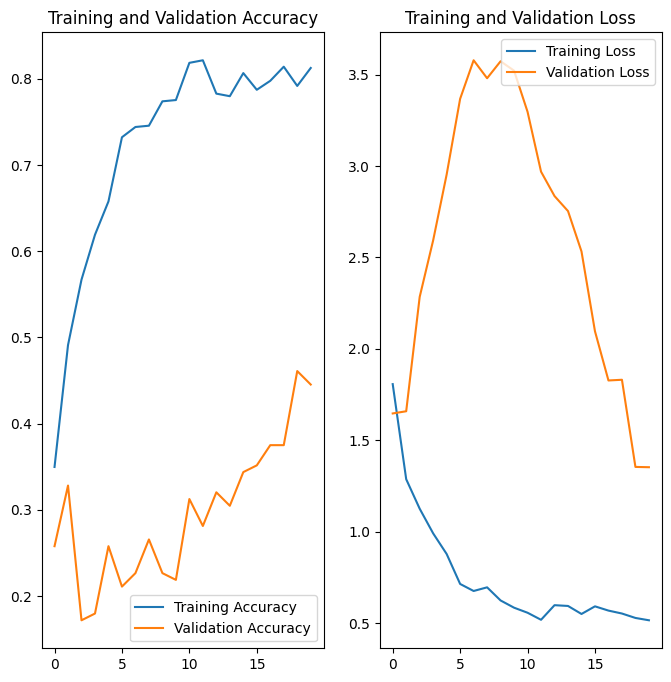

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##**Model 2**

In above model we see the validation accuracy is varing wildly. Adding more epochs may give the stable validation accuracy. Before doing that we would try what effect batch_size of 64 have on the model. For this model we will try batch_zise and 64

In [ ]:
new_batch_size = 64
train_generator = generator(train_path, train_doc, new_batch_size)
val_generator = generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 80, 80, 32)    2624      
                                                                 
 activation (Activation)     (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization (BatchN  (None, 13, 80, 80, 32)   128       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 40, 40, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_1 (Activation)   (None, 6, 40, 40, 64)     0

In [ ]:
num_epochs2=30
history2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs2, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/My Drive/Project_data/train ; batch size = 64
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 0.5394 - categorical_accuracy: 0.7917Source path =  /content/drive/My Drive/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2023-06-0615_01_44.522582/model-00001-0.53943-0.79167-1.03360-0.59375.h5
21/21 [==============================] - 164s 8s/step - loss: 0.5394 - categorical_accuracy: 0.7917 - val_loss: 1.0336 - val_categorical_accuracy: 0.5938 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.4388 - categorical_accuracy: 0.8378
Epoch 2: saving model to model_init_2023-06-0615_01_44.522582/model-00002-0.43879-0.83780-1.18506-0.50000.h5
21/21 [==============================] - 163s 8s/step - loss: 0.4388 - categorical_accuracy: 0.8378 - val_loss: 1.1851 - val_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.3536 - categoric

<Figure size 1000x1000 with 0 Axes>

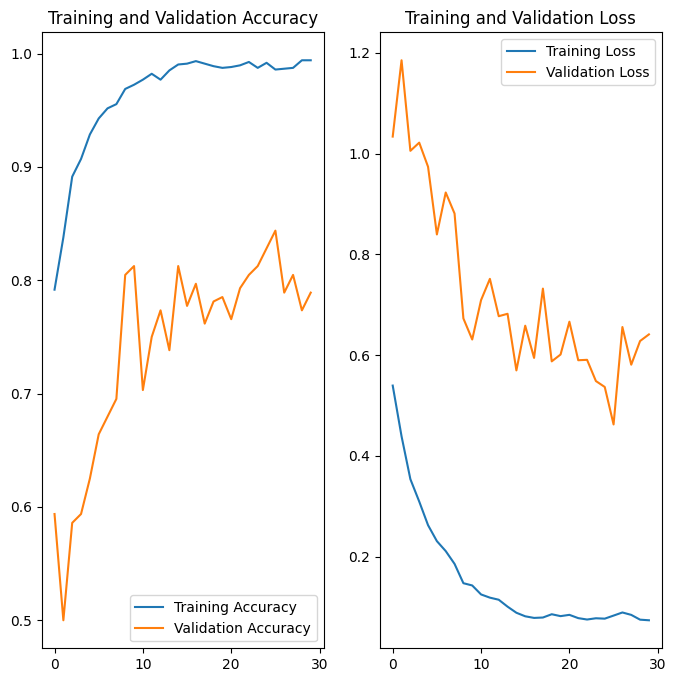

In [ ]:
plt.figure(figsize = (10,10))

acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(num_epochs2)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##**Model 3**

As we saw the validation accuracy is increased in the previous model with higher number of epochs and batch size. Now we can experiment if we can get better results by improving the image resolution. Previously we tried with the 80 * 80 image resolution and only 13 images from the set we considered. Now we will use 120 * 120 image resolution and we will use 20 images from each video frames.

In [ ]:
def new_generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,20,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = resize(image,(120,120)).astype(np.float32)
                    
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            batch_data = np.zeros((batch_size,20,120,120,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image,(120,120)).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield does   

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/My Drive/Project_data//train'
val_path = '/content/drive/My Drive/Project_data//val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(20,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [ ]:
new_batch_size = 32
train_generator = new_generator(train_path, train_doc, new_batch_size)
val_generator = new_generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 20, 120, 120, 32)  2624      
                                                                 
 activation_3 (Activation)   (None, 20, 120, 120, 32)  0         
                                                                 
 batch_normalization_5 (Batc  (None, 20, 120, 120, 32)  128      
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 10, 60, 60, 32)   0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 10, 60, 60, 64)    16448     
                                                                 
 activation_4 (Activation)   (None, 10, 60, 60, 64)   

In [ ]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%new_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/new_batch_size)
else:
    steps_per_epoch = (num_train_sequences//new_batch_size) + 1

if (num_val_sequences%new_batch_size) == 0:
    validation_steps = int(num_val_sequences/new_batch_size)
else:
    validation_steps = (num_val_sequences//new_batch_size) + 1

In [ ]:
num_epochs3=20
history3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs3, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/My Drive/Project_data//train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.5582 - categorical_accuracy: 0.4167 Source path =  /content/drive/My Drive/Project_data//val ; batch size = 32

Epoch 1: saving model to model_init_2023-06-0617_37_44.745996/model-00001-1.55818-0.41667-1.57130-0.24219.h5
21/21 [==============================] - 1055s 52s/step - loss: 1.5582 - categorical_accuracy: 0.4167 - val_loss: 1.5713 - val_categorical_accuracy: 0.2422 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.0774 - categorical_accuracy: 0.5804
Epoch 2: saving model to model_init_2023-06-0617_37_44.745996/model-00002-1.07737-0.58036-2.84284-0.14062.h5
21/21 [==============================] - 169s 8s/step - loss: 1.0774 - categorical_accuracy: 0.5804 - val_loss: 2.8428 - val_categorical_accuracy: 0.1406 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.9099 - cate

<Figure size 1000x1000 with 0 Axes>

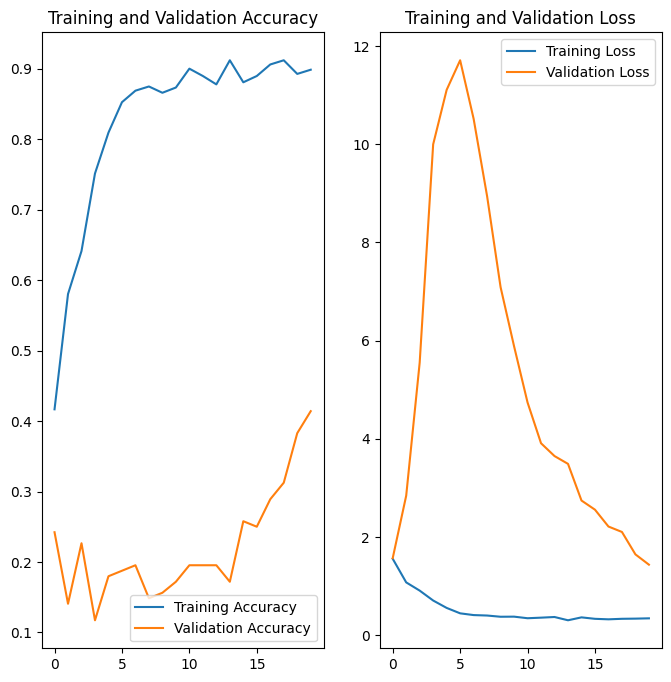

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))

acc = history3.history['categorical_accuracy']
val_acc = history3.history['val_categorical_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(num_epochs3)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Model 4**

In above model we can see the model is overfitting as the validation accuracy is dropped drastically. We will now experiment if increasing the no of epochs help to increase the validation accuracy as we saw in the first two models. Or we will need to go for augmenting to create more training dat to avoid overfitting.

In [ ]:
num_epochs4=40
history4 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs4, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/40
21/21 [==============================] - ETA: 0s - loss: 0.3465 - categorical_accuracy: 0.9077
Epoch 1: saving model to model_init_2023-06-0617_37_44.745996/model-00001-0.34649-0.90774-1.38453-0.45312.h5
21/21 [==============================] - 139s 7s/step - loss: 0.3465 - categorical_accuracy: 0.9077 - val_loss: 1.3845 - val_categorical_accuracy: 0.4531 - lr: 1.6000e-05
Epoch 2/40
21/21 [==============================] - ETA: 0s - loss: 0.3467 - categorical_accuracy: 0.8884
Epoch 2: saving model to model_init_2023-06-0617_37_44.745996/model-00002-0.34671-0.88839-1.24873-0.46094.h5
21/21 [==============================] - 142s 7s/step - loss: 0.3467 - categorical_accuracy: 0.8884 - val_loss: 1.2487 - val_categorical_accuracy: 0.4609 - lr: 1.6000e-05
Epoch 3/40
21/21 [==============================] - ETA: 0s - loss: 0.3531 - categorical_accuracy: 0.8929
Epoch 3: saving model to model_init_2023-06-0617_37_44.745996/model-00003-0.35306-0.89286-0.98259-0.65625.h5
21/21 [======

<Figure size 1000x1000 with 0 Axes>

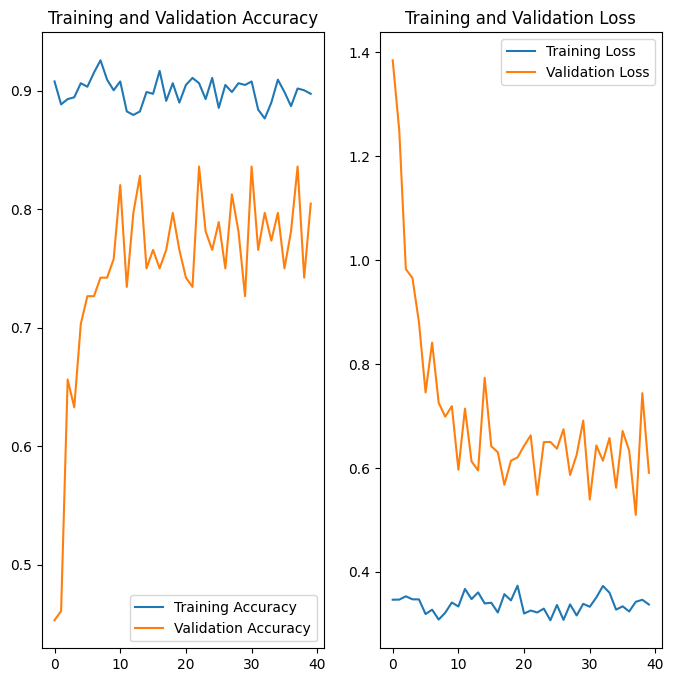

In [ ]:
plt.figure(figsize = (10,10))

acc = history4.history['categorical_accuracy']
val_acc = history4.history['val_categorical_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(num_epochs4)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Model 5**

In previous model we saw that validation accuracy is increased compared to the previous model, but it is not able to increase above the threshold of 0.80 where the training accuracy have reached 0.90. This concludes no of epochs increased do not help much in improving the model which is overfitting.

Now we will try to implement the CNN + LSTM model and will compare the results with the second model which had highest validation accuracy.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

from keras.layers import LSTM

#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(13,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [ ]:
batch_size = 32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 13, 80, 80, 32)    2624      
                                                                 
 activation_9 (Activation)   (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization_14 (Bat  (None, 13, 80, 80, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 6, 40, 40, 32)    0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_10 (Activation)  (None, 6, 40, 40, 64)    

In [ ]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%new_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/new_batch_size)
else:
    steps_per_epoch = (num_train_sequences//new_batch_size) + 1

if (num_val_sequences%new_batch_size) == 0:
    validation_steps = int(num_val_sequences/new_batch_size)
else:
    validation_steps = (num_val_sequences//new_batch_size) + 1

In [ ]:
num_epochs5=20
history5 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs5, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/My Drive/Project_data//train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.9470 - categorical_accuracy: 0.2932Source path =  /content/drive/My Drive/Project_data//val ; batch size = 32

Epoch 1: saving model to model_init_2023-06-0617_37_44.745996/model-00001-1.94701-0.29315-1.58962-0.24219.h5
21/21 [==============================] - 83s 4s/step - loss: 1.9470 - categorical_accuracy: 0.2932 - val_loss: 1.5896 - val_categorical_accuracy: 0.2422 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5902 - categorical_accuracy: 0.3958
Epoch 2: saving model to model_init_2023-06-0617_37_44.745996/model-00002-1.59019-0.39583-1.58596-0.25000.h5
21/21 [==============================] - 82s 4s/step - loss: 1.5902 - categorical_accuracy: 0.3958 - val_loss: 1.5860 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.4946 - categoric

<Figure size 1000x1000 with 0 Axes>

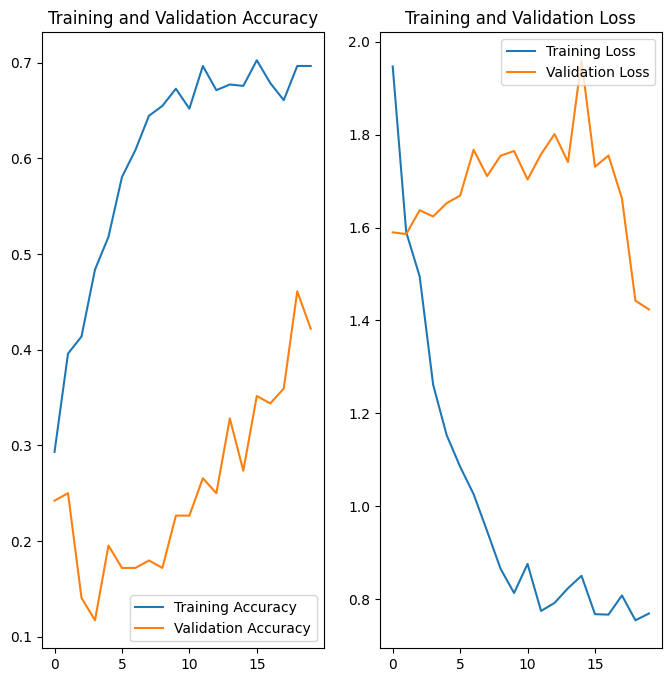

In [ ]:
plt.figure(figsize = (10,10))

acc = history5.history['categorical_accuracy']
val_acc = history5.history['val_categorical_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(num_epochs3)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Model 6**

In previous model model is having overall less training and validation accuracy, but we see steady trend in increasing the training and validation accuracy. Adding more epochs can help here to further improve the accuracy.

In [ ]:
num_epochs6=40
history6 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs6, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/40
21/21 [==============================] - ETA: 0s - loss: 0.7690 - categorical_accuracy: 0.7068
Epoch 1: saving model to model_init_2023-06-0617_37_44.745996/model-00001-0.76900-0.70685-1.33591-0.50000.h5
21/21 [==============================] - 82s 4s/step - loss: 0.7690 - categorical_accuracy: 0.7068 - val_loss: 1.3359 - val_categorical_accuracy: 0.5000 - lr: 1.6000e-05
Epoch 2/40
21/21 [==============================] - ETA: 0s - loss: 0.7745 - categorical_accuracy: 0.6786
Epoch 2: saving model to model_init_2023-06-0617_37_44.745996/model-00002-0.77446-0.67857-1.27180-0.57812.h5
21/21 [==============================] - 81s 4s/step - loss: 0.7745 - categorical_accuracy: 0.6786 - val_loss: 1.2718 - val_categorical_accuracy: 0.5781 - lr: 1.6000e-05
Epoch 3/40
21/21 [==============================] - ETA: 0s - loss: 0.8037 - categorical_accuracy: 0.6890
Epoch 3: saving model to model_init_2023-06-0617_37_44.745996/model-00003-0.80373-0.68899-1.15075-0.49219.h5
21/21 [========

<Figure size 1000x1000 with 0 Axes>

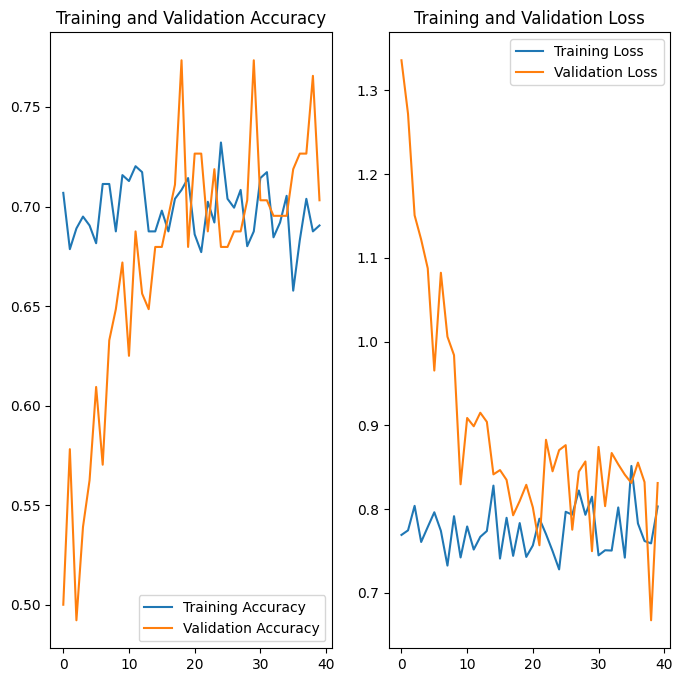

In [ ]:
plt.figure(figsize = (10,10))

acc = history6.history['categorical_accuracy']
val_acc = history6.history['val_categorical_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs_range = range(num_epochs6)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In This model validationaccuracy crosses training accuracy lets test onsome more epochs

## **Model 7**

In [ ]:
num_epochs7=20
history7 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs7, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 0.7669 - categorical_accuracy: 0.7009
Epoch 1: saving model to model_init_2023-06-0617_37_44.745996/model-00001-0.76694-0.70089-0.84135-0.69531.h5
21/21 [==============================] - 82s 4s/step - loss: 0.7669 - categorical_accuracy: 0.7009 - val_loss: 0.8413 - val_categorical_accuracy: 0.6953 - lr: 2.5600e-08
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.7615 - categorical_accuracy: 0.6741
Epoch 2: saving model to model_init_2023-06-0617_37_44.745996/model-00002-0.76154-0.67411-0.84365-0.71094.h5
21/21 [==============================] - 82s 4s/step - loss: 0.7615 - categorical_accuracy: 0.6741 - val_loss: 0.8437 - val_categorical_accuracy: 0.7109 - lr: 2.5600e-08
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.7844 - categorical_accuracy: 0.6935
Epoch 3: saving model to model_init_2023-06-0617_37_44.745996/model-00003-0.78440-0.69345-0.80481-0.68750.h5
21/21 [========

<Figure size 1000x1000 with 0 Axes>

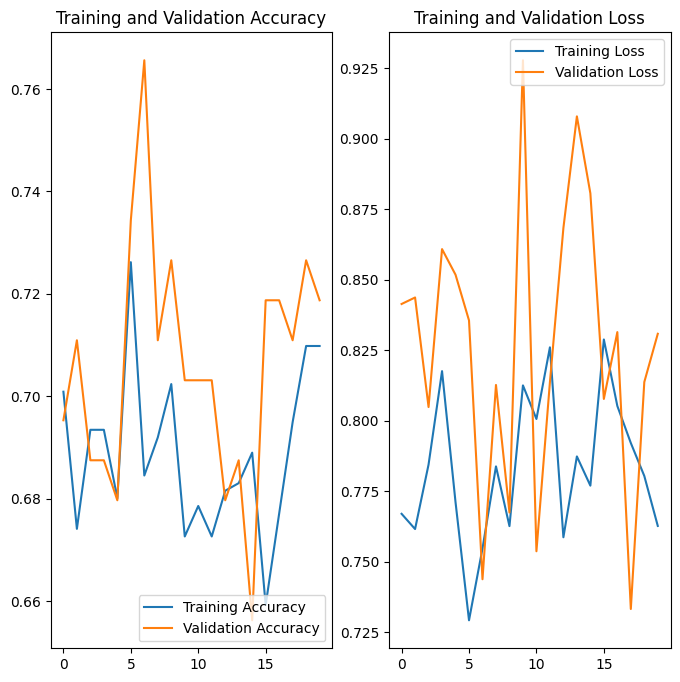

In [ ]:
plt.figure(figsize = (10,10))

acc = history7.history['categorical_accuracy']
val_acc = history7.history['val_categorical_accuracy']

loss = history7.history['loss']
val_loss = history7.history['val_loss']

epochs_range = range(num_epochs7)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Although the model is not super ,we can consider this and can improve by giving more training